# Overview

This colab demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image. Expected outputs are semantic labels overlayed on the sample image.

### About DeepLab
The models used in this colab perform semantic segmentation. Semantic segmentation models focus on assigning semantic labels, such as sky, person, or car, to multiple objects and stuff in a single image.

### Build the model

**[DeepLab](https://github.com/tensorflow/models/tree/master/research/deeplab)** is a state-of-art deep learning model for semantic image segmentation, where the goal is to assign semantic labels (e.g., person, dog, cat and so on) to every pixel in the input image. Some segmentation results on Flickr images:

In the driving context, we aim to obtain a semantic understanding of the front driving scene throught the camera input. This is important for driving safety and an essential requirement for all levels of autonomous driving. The first step is to build the model and load the pre-trained weights. In this demo, we use the model checkpoint trained on [Cityscapes](https://www.cityscapes-dataset.com/) dataset.

|Road, Pedestrian, Bicycle, Traffic sign|Road, Car,Traffic Sign, Traffic Light |
|--|--|
| <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png" width=400/> | <img src="https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/zuerich00.png" width=400/> |

# Instructions
<h3><a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a>  &nbsp;&nbsp;Use a free TPU device</h3>

   1. On the main menu, click Runtime and select **Change runtime type**. Set "TPU" as the hardware accelerator.
   1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER.

## Import Libraries

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  #if label.ndim != 2:
  #  raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [3]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://github.com/tooth2/SSD-Object-Detection/blob/main/images/pedestrian_bike.jpeg?raw=true...


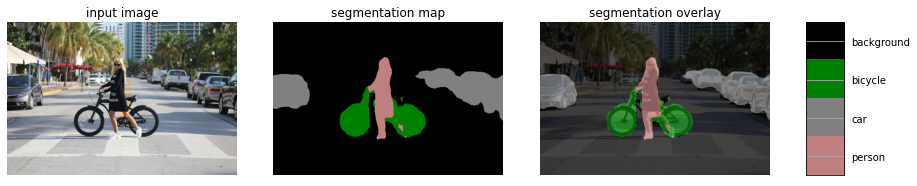

In [4]:

SAMPLE_IMAGE = 'image2'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = 'https://github.com/tooth2/SSD-Object-Detection/blob/main/images/pedestrian_bike.jpeg?raw=true'  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

## What's next

* Learn about [Cloud TPUs](https://cloud.google.com/tpu/docs) that Google designed and optimized specifically to speed up and scale up ML workloads for training and inference and to enable ML engineers and researchers to iterate more quickly.
* Explore the range of [Cloud TPU tutorials and Colabs](https://cloud.google.com/tpu/docs/tutorials) to find other examples that can be used when implementing your ML project.
* For more information on running the DeepLab model on Cloud TPUs, see the [DeepLab tutorial](https://cloud.google.com/tpu/docs/tutorials/deeplab).


In [45]:
import cv2 as cv
from tqdm import tqdm
import IPython
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg

new_clip=[]
def vis_segmentation_stream(image, seg_map):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay | frame')
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig('{}.jpg'.format(i))
    
    new_clip = f    

    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()
    return new_clip;


def run_visualization_video(frame):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    resized_im, seg_map = MODEL.run(original_im)
    #vis_segmentation_stream(original_im, seg_map, index)
    vis_segmentation_stream(resized_im, seg_map)


SAMPLE_VIDEO = 'sample.mp4'
if not os.path.isfile(SAMPLE_VIDEO): 
    print('downloading the sample video...')
    SAMPLE_VIDEO = urllib.request.urlretrieve('https://github.com/tooth2/SSD-Object-Detection/blob/main/sample.mp4?raw=true')[0]
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
num_frames = 298  # the full sample video frames = 598
#num_frames = 30
#video_out = cv.VideoWriter('result.mp4', cv.VideoWriter_fourcc('A','V','C','1'), 1,  (640,  480) ) #(mat.shape[0],mat.shape[1])
frames = []
try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        new_clip = run_visualization_video(frame)
        plt.show(new_clip)
        
        #plt.savefig("file%02d.png" % i)
        #animation = VideoClip(make_frame, duration=duration)
        #new_clip=cv.cvtColor(new_clip, cv.COLOR_RGB2BGR)
        IPython.display.clear_output(wait=True)
        #video_out.write(new_clip)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
#output='result.mp4'
#clip1 = VideoFileClip(SAMPLE_VIDEO)
#clip = clip1.fl_image(run_visualization_video)
#%time clip.write_videofile(output, audio=False)

Stream stopped.


# New Section

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

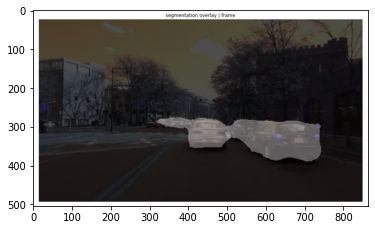

In [50]:
from moviepy.editor import ImageSequenceClip
import glob
#from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
image_folder="/content"
video_name = "result.mp4"
images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]

fnames = sorted([fname for fname in os.listdir(image_folder) 
        if fname.endswith('.jpg')], 
        key=lambda f: int(f.rsplit(os.path.extsep, 1)[0].rsplit(None,1)[-1]))
print(fnames)
frame = cv.imread(os.path.join(image_folder, images[297]))
if frame is not None:
  plt.imshow(frame)#
height, width, layers = frame.shape
fps= 30 
size = (width, height)
print(size)
frames=[]

video_out = cv.VideoWriter(video_name, cv.VideoWriter_fourcc(*'mp4v'), fps, size)


frame_array = []   
for i in range(len(fnames)):
    image = cv.imread(os.path.join(image_folder, fnames[i]))
    frame_array.append(image)

for i in range(0,298):
    # writing to a image array
    video_out.write(frame_array[i])  

cv.destroyAllWindows()
video_out.release()



In [58]:
HTML("""
<video width="864" height="504" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('result.mp4'))
